In [1]:
import festim as F
import fenics as f
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

################### PARAMETERS ###################
N_A_const = 6.022e23 # Avogadro, mol^-1
e = 1.602e-19
M_H2 = 2.016e-3 / N_A_const # the H2 mass, kg mol^-1

# Sample size
A = 1e-2 * 1.3e-2 # Ti surface area (1cm x 1.3cm), m^2
L = 1e-3 / 2 # Ti thickness, m
V = A * L # Ti volume (1cm x 1.3cm x 1mm), m^-3

# Ti properties
N_b = 9.4e4 * N_A_const #  the number of atomic sites per unit of volume of Ti, m^-3
N_s = 2.16e-5 * N_A_const # the number of atomic sites per unit of surface area of Ti, m^-2
n_Ti = N_b * V  #  the number of moles of Ti
lambda_Ti = N_s / N_b

# Properties of fluxes
E_diff = F.kJmol_to_eV(5.3e4 / 1e3) # diffusion activation energy, eV
D0 = 9e-7 # Diffusion pre-factor for D in W, m^2 s^-1

E_des = F.kJmol_to_eV(1.17e5 / 1e3) # activateion energy for desotpion, eV
k_des = 2.16e8 * N_A_const # frequency factor for the surface desorption

E_sb = F.kJmol_to_eV(1.36e5 / 1e3) # the activation energy value for the inward subsurface transport, eV
k_sb = 8.56e12 # frequency factor for the inward subsurface transport, s^-1

E_bs = F.kJmol_to_eV(1.6e5 / 1e3) # the activation energy value for the outward subsurface transport, eV
k_bs = 7.77e13 # frequency factor for the outward subsurface transport, s^-1

# Chamber
V_ch = 2.95e-3 # the chamber volume, m^-3
P0 = 1.3e4 # the initial pressure, Pa

################### FUNCTIONS ################### 

# Explicit approach

In [2]:
def S0(T):
    # the capturing coefficient
    return 0.0143 * f.exp(F.kJmol_to_eV(1.99) / F.k_B / T)

def P_H2(T, X):
    # partial pressure of hydrogen, Pa
    X0 = 0
    return F.k_B * T * e / V_ch * (P0 * V_ch / (F.k_B * T * e) +  (X0 - X) * (2*n_Ti) / 2)

def J_sb(T, theta, mobile_conc):
    # the hydrogen flux for the inward subsurface transport,  m^-2 s^-1
    return k_sb * N_s * theta * (1-mobile_conc/N_b) * f.exp(-E_sb / F.k_B / T)

def J_bs(T, theta, mobile_conc):
    # the hydrogen flux for the outward subsurface transport,  m^-2 s^-1
    return k_bs * N_s * (mobile_conc/N_b) * (1-theta) * f.exp(-E_bs / F.k_B / T)

def theta_eq(T, X):
    alpha = 2 * S0(T) * P_H2(T, X) / k_des / f.exp(-E_des / F.k_B / T) / (2 * np.pi * M_H2 * F.k_B * T * e)**0.5
    return alpha**0.5 / (1 + alpha**0.5)

def LeftFlux(T, mobile_conc, dmobile_conc, X):
    theta = theta_eq(T, X)
    return -lambda_Ti * dmobile_conc + J_sb(T, theta, mobile_conc) - J_bs(T, theta, mobile_conc)

################### CUSTOM MODEL CLASS ###################
class CustomSimulation(F.Simulation):
    def iterate(self):
        prev_sol = self.mobile.solution(0)
        super().iterate()

        # Surface concentration based on flux
        X_old = left_surface_bc.prms["X"]
        surf_conc = theta_eq(self.T.T(0), X_old) * N_s

        # FLuxes
        X = (f.assemble(self.mobile.solution * self.mesh.dx) + surf_conc) * A / n_Ti
        dmobile_conc = (self.mobile.solution(0) - prev_sol) / float(self.dt.value)

        # Update surface and subsurface concentrations
        left_surface_bc.prms['dmobile_conc'].assign(dmobile_conc)
        left_surface_bc.prms['X'].assign(X)
        
################### CUSTOM EXPORT CLASS ###################
class Content(F.SurfaceQuantity):
    def __init__(self, surface) -> None:
        super().__init__(field="solute", surface=surface)

    @property
    def title(self):
        quantity_title = f"Content"
        return quantity_title

    def compute(self):
        return float(left_surface_bc.prms['X'])
    
################### MODEL ###################
for i, T0 in enumerate([450+273, 500+273, 550+273, 600+273, 650+273]):
    Ti_model = CustomSimulation(log_level = 40)

    # Mesh
    vertices = np.linspace(0, L, num = 251)
    Ti_model.mesh = F.MeshFromVertices(np.sort(vertices))

    # Materials
    Ti_model.materials = F.Material(id=1, D_0=D0, E_D=E_diff)

    # Boundary conditions
    left_surface_bc = F.CustomFlux(surfaces=1, field = "solute", function = LeftFlux, X=0, dmobile_conc=0)

    Ti_model.boundary_conditions = [left_surface_bc]

    # Exports
    n_exp = 10
    results_folder = "test/"

    derived_quantities = [F.DerivedQuantities([F.HydrogenFlux(surface=1), 
                                            F.TotalVolume(field='solute', volume=1),
                                            Content(surface = 1)],
                                            nb_iterations_between_compute = 1,
                                            filename=results_folder + f"derived_quantities_expl_{T0}.csv")]

    Ti_model.exports = derived_quantities

    Ti_model.T = F.Temperature(value=T0)

    Ti_model.dt = F.Stepsize(
        initial_value=1e-3,
        stepsize_change_ratio=1.1,
        max_stepsize=5,
        dt_min=1e-4
    )

    Ti_model.settings = F.Settings(
        absolute_tolerance=1e10,
        relative_tolerance=1e-5,
        maximum_iterations=50,
        final_time=25*60,
    )

    
    Ti_model.initialise()
    Ti_model.run()


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 3.6 s


# Implicit

In [3]:
def S0(T):
    # the capturing coefficient
    return 0.0143 * f.exp(F.kJmol_to_eV(1.99) / F.k_B / T)

def P_H2(T, X):
    # partial pressure of hydrogen, Pa
    X0 = 0
    return F.k_B * T * e / V_ch * (P0 * V_ch / (F.k_B * T * e) +  (X0 - X) * (2*n_Ti) / 2)

def J_vs(surf_conc, T, X):
    J_ads = 2 * S0(T) * (1 - surf_conc / N_s) ** 2 * P_H2(T, X)  / (2*np.pi*M_H2*F.k_B*T*e)**0.5
    J_des = k_des * (surf_conc / N_s) ** 2 * f.exp(-E_des/F.k_B/T)
    return J_ads - J_des

def K_sb(surf_conc, T, X):
    return k_sb * f.exp(-E_sb/F.k_B/T)

def K_bs(surf_conc, T, X):
    return k_bs * f.exp(-E_bs/F.k_B/T)
################### CUSTOM MODEL CLASS ###################
class CustomSimulation(F.Simulation):
    def iterate(self):
        super().iterate()

        # Content
        X = (f.assemble(self.mobile.solution * self.mesh.dx)) * A / n_Ti

        # Update surface and subsurface concentrations
        self.h_transport_problem.surface_concentrations[0].prms["X"].assign(X)
    
################### MODEL ###################
for i, T0 in enumerate([450+273, 500+273, 550+273, 600+273, 650+273]):
    Ti_model_impl = CustomSimulation(log_level = 40)

    # Mesh
    vertices = np.linspace(0, L, num = 251)
    Ti_model_impl.mesh = F.MeshFromVertices(np.sort(vertices))

    # Materials
    Ti_model_impl.materials = F.Material(id=1, D_0=D0, E_D=E_diff)

    surf_conc = F.SurfaceConcentration(K_sb, K_bs, lambda_Ti, N_s, N_b, J_vs, 1, F.InitialCondition("adsorbed", 0),X=0)
    Ti_model_impl.surface_concentrations = [surf_conc]

    # Exports
    n_exp = 10
    results_folder = "test/"

    derived_quantities = [F.DerivedQuantities([ 
                                                F.AdsorbedHydrogen(surface=1),
                                                F.TotalVolume(field="solute", volume = 1)],
                                                nb_iterations_between_compute = 1,
                                                filename=results_folder + f"derived_quantities_impl_{T0}.csv")]

    Ti_model_impl.exports = derived_quantities

    Ti_model_impl.T = F.Temperature(value=T0)

    Ti_model_impl.dt = F.Stepsize(
        initial_value=1e-3,
        stepsize_change_ratio=1.1,
        max_stepsize=5,
        dt_min=1e-4
    )

    Ti_model_impl.settings = F.Settings(
        absolute_tolerance=1e10,
        relative_tolerance=1e-5,
        maximum_iterations=50,
        final_time=25*60,
    )

    
    Ti_model_impl.initialise()
    Ti_model_impl.run()


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        1.5e+03 s    Elapsed time so far: 6.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so

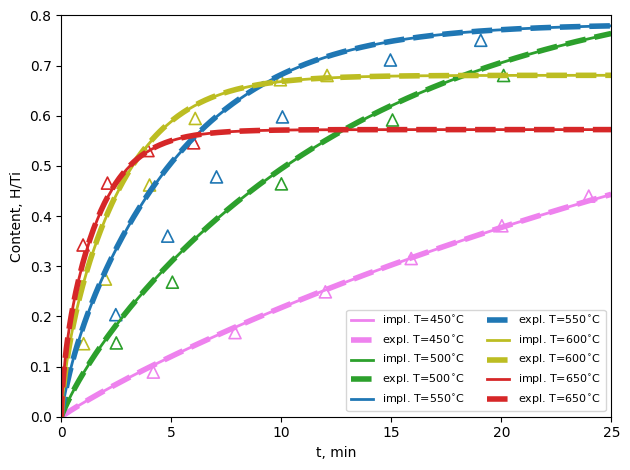

In [4]:
colors = ["violet", "tab:green", "tab:blue", "tab:olive", "tab:red"]
for i, T0 in enumerate([450+273, 500+273, 550+273, 600+273, 650+273]):
    data_impl = pd.read_csv(f"./test/derived_quantities_impl_{T0}.csv", header = 0)
    plt.plot(data_impl["t(s)"]/60, data_impl["Total solute volume 1"] * A / n_Ti, color = colors[i], lw = 2, label = f"impl. T={T0-273}"+ r"$^{\circ}$C", ls = 'solid')

    data_expl = pd.read_csv(f"./test/derived_quantities_expl_{T0}.csv", header = 0)
    plt.plot(data_expl["t(s)"]/60, data_expl["Total solute volume 1"] * A / n_Ti, color = colors[i], lw = 4, label = f"expl. T={T0-273}"+ r"$^{\circ}$C", ls = 'dashed')

    exp = pd.read_csv(f"./exp_data/{T0-273}.csv", header=None, skiprows = 1, sep=",")
    plt.scatter(exp[0], exp[1], edgecolors = colors[i], facecolors='none', marker = '^', s = 75, linewidths=1.2)


plt.ylabel('Content, H/Ti', fontsize = 10)
plt.xlabel('t, min', fontsize = 10)
plt.ylim(0,0.8)
plt.xlim(0,25)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.legend(fontsize = 8, ncols = 2)
plt.tight_layout()
plt.show()